In [ ]:
# GD with momentum: https://github.com/VinitSR7/Logistic-Regression-with-Advanced-Optimizers/blob/master/SGD%20with%20Momentum.ipynb
# Benchmarks: https://arxiv.org/pdf/2306.07179, https://openreview.net/pdf?id=HygrAR4tPS
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from optimizers import *
from train import *


data = datasets.load_breast_cancer()
X = data['data']
Y = data['target']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify = Y, shuffle = True)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


pars_kd = {
    'c0': 1.,
    'gamma': 25.,
    'eps': 1e-4,
    'k': 0.5,
    'decay': {'c': lambda t, P: P['eps'] + (P['c0'] - P['eps']) * (1 + np.cos(np.pi * (t % P['gamma']) / P['gamma'])) / 2 * (P['k'] ** (t // P['gamma'])),
              'cp': lambda t, P: -0.5 * (P['c0'] - P['eps']) * (np.pi / P['gamma']) * np.sin(np.pi * (t % P['gamma']) / P['gamma']) * (P['k'] ** (t // P['gamma'])),
              'csqrt': lambda t, P: np.sqrt(P['decay']['c'](t, P))}
            }
    #'c': lambda t, P: P['eps'] + (P['c0'] - P['eps']) * (1 + np.cos(np.pi * t / P['gamma'])) / 2, #P['c0'] * (1 + t)**(-P['gamma']), #np.exp(-P['gamma'] * t), #(1 + 10**P['gamma'] * np.log(t + 1))**(-1), #P['c0'] * (1 + t)**(-P['gamma']), #P['c0']/(1+P['gamma']*t),
    #'cp': lambda t, P: -0.5 * (P['c0'] - P['eps']) * (np.pi/P['gamma']) * np.sin(np.pi * t / P['gamma']),#-P['gamma'] * P['c0'] * (1 + t)**(-P['gamma']-1), #-P['gamma'] * np.exp(-P['gamma'] * t), #-10**P['gamma'] * ((1 + 10**P['gamma'] * np.log(t + 1))**2 * (t + 1))**(-1), #-P['gamma'] * P['c0'] * (1 + t)**(-P['gamma']-1), #-P['gamma'] * P['c0']/((1+P['gamma']*t)**2),
    #'csqrt': lambda t, P: np.sqrt(P['decay']['c'](t, P)) #np.sqrt(P['c0'] * (1 + t)**(-P['gamma'])) #np.sqrt(np.exp(-P['gamma'] * t)) #np.sqrt(((1 + 10**P['gamma'] * np.log(t + 1)))**(-1)) #np.sqrt(P['c0']/(1+P['gamma']*t))#np.sqrt(np.exp(-P['gamma'] * t))
#}}

epochs = 500
batch_size = 64
eta = 1e-1
N = X_train.shape[1]
np.random.seed(42)
w = np.random.randn(N).reshape(N, 1)
ws_kd_ub, ps_kd_ub, loss_kd_ub, train_acc_kd_ub, test_acc_kd_ub = train(w, X_train, Y_train, X_test, Y_test, epochs, eta = eta, pars = pars_kd, optimizer = 'kd_ub', batch_size = batch_size)
#w_hd, ps, loss_hd, train_acc_hd, test_acc_hd = train(w, X_train, Y_train, X_test, Y_test, epochs, eta = eta, pars = {'gamma': 1.}, optimizer = 'hd', batch_size = batch_size)
ws_gdm, ps_gdm, loss_gdm, train_acc_gdm, test_acc_gdm = train(w, X_train, Y_train, X_test, Y_test, epochs, eta = eta, pars = {'beta': 0.821111}, optimizer = 'gdm', batch_size = batch_size)
w_kd_ub, w_gdm = ws_kd_ub[-1], ws_gdm[-1]

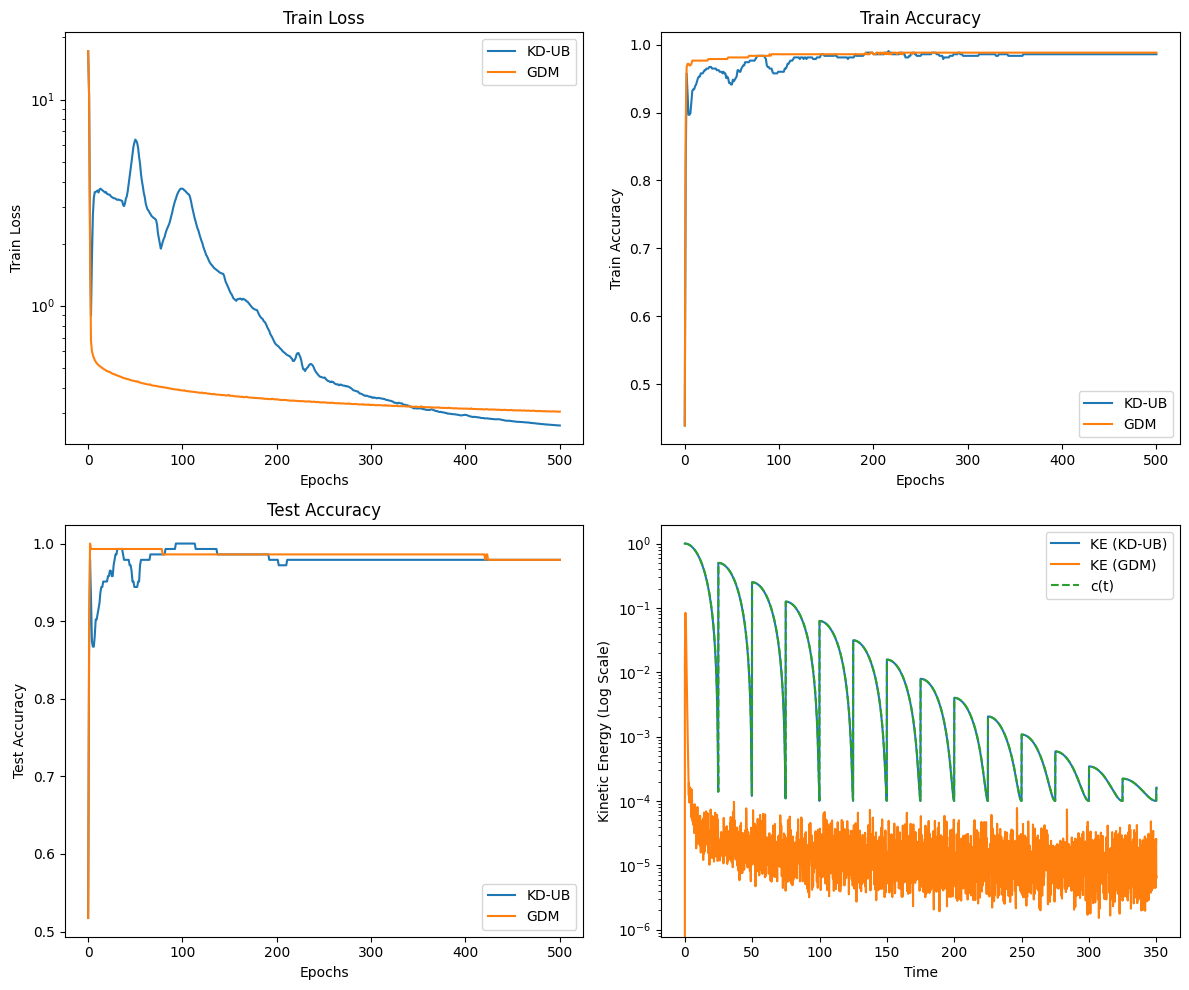

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Train Loss
ax[0, 0].semilogy(np.arange(epochs+1), loss_kd_ub, label='KD-UB')
ax[0, 0].semilogy(np.arange(epochs+1), loss_gdm, label='GDM')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Train Loss')
ax[0, 0].legend()
ax[0, 0].set_title('Train Loss')

# Plot 2: Train Accuracy
ax[0, 1].plot(np.arange(epochs+1), train_acc_kd_ub, label='KD-UB')
ax[0, 1].plot(np.arange(epochs+1), train_acc_gdm, label='GDM')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('Train Accuracy')
ax[0, 1].legend()
ax[0, 1].set_title('Train Accuracy')

# Plot 3: Test Accuracy
ax[1, 0].plot(np.arange(epochs+1), test_acc_kd_ub, label='KD-UB')
ax[1, 0].plot(np.arange(epochs+1), test_acc_gdm, label='GDM')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('Test Accuracy')
ax[1, 0].legend()
ax[1, 0].set_title('Test Accuracy')

# Plot 4: KE vs. Desired KE
T = np.arange((np.ceil(len(X_train) / batch_size))*epochs + 1) * eta
ax[1, 1].semilogy(T, 0.5 * (np.linalg.norm(ps_kd_ub, axis=1)**2).reshape(-1), label='KE (KD-UB)')
ax[1, 1].semilogy(T, 0.5 * (np.linalg.norm(ps_gdm, axis=1)**2).reshape(-1), label='KE (GDM)')
ax[1, 1].semilogy(T, pars_kd['decay']['c'](T, pars_kd).reshape(-1), label='c(t)', linestyle='--')
ax[1, 1].set_xlabel('Time')
ax[1, 1].set_ylabel('Kinetic Energy (Log Scale)')
ax[1, 1].legend()
plt.tight_layout()  
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


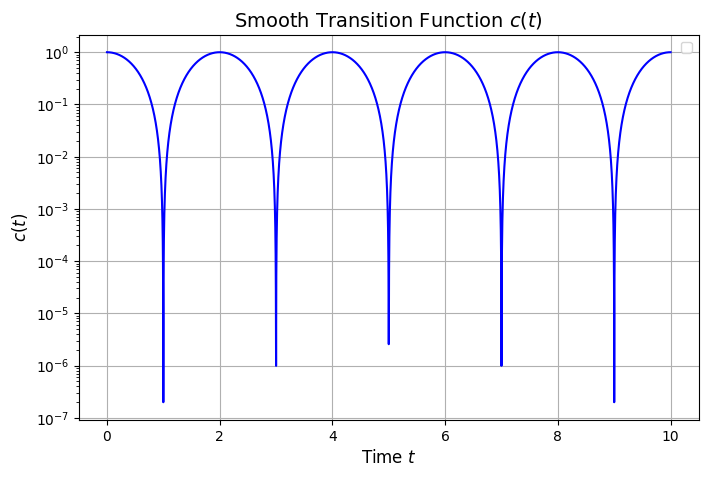

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def c(t, gamma, c_min = 1e-7, c_max = 1):
    return c_min + (c_max - c_min) * (1 + np.cos(np.pi * t / gamma)) / 2

# Parameters for visualization
gamma = 1   # Stagnation value

# Generate time values
t = np.linspace(0, 10, 5000)
c_values = c(t, gamma)

# Plot the function
plt.figure(figsize=(8, 5))
plt.semilogy(t, c_values, color='blue')
plt.title('Smooth Transition Function $c(t)$', fontsize=14)
plt.xlabel('Time $t$', fontsize=12)
plt.ylabel('$c(t)$', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


# Hyperparameter Optimization

In [ ]:
import numpy as np
from itertools import product
import pandas as pd

eta_values = np.logspace(-3, -1, 10)
c0_values = [0.1, 0.5, 1.0, 5.0]
gamma_values = np.linspace(0.05, 0.95, 10)
batch_size_values = [16, 32, 64, 128, 256]
eps = [1e-6, 1e-8, 1e-10]
epochs = 100

results = []

for eta, c0, gamma, batch_size in product(eta_values, c0_values, gamma_values, batch_size_values):
    print(f"Training with eta={eta:.5e}, c0={c0:.5f}, gamma={gamma:.5f}, batch_size={batch_size}")
    pars_kd = {
        'c0': c0,
        'gamma': gamma,
        'decay': {
            'c': lambda t, P: np.maximum(np.exp(-P['gamma'] * t), eps),
            'cp': lambda t, P: np.where(
                np.exp(-P['gamma'] * t) > eps,
                -P['gamma'] * np.exp(-P['gamma'] * t),
                0.0
            ),
            'csqrt': lambda t, P: np.sqrt(np.maximum(np.exp(-P['gamma'] * t), eps))
        }
    }
    try:
        w_kd_rk4, ps_kd_rk4, loss_kd_rk4, train_acc_kd_rk4, test_acc_kd_rk4 = train(
            X_train, Y_train, X_test, Y_test,
            epochs=epochs,
            eta=eta,
            pars=pars_kd,
            optimizer='kd_rk4',
            batch_size=batch_size
        )
        results.append({
            'eta': eta,
            'c0': c0,
            'gamma': gamma,
            'batch_size': batch_size,
            'final_train_accuracy': train_acc_kd_rk4[-1],
            'final_test_accuracy': test_acc_kd_rk4[-1],
            'final_loss': loss_kd_rk4[-1]
        })
    except Exception as e:
        print(f"Skipped due to error: {e}")
        continue

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='final_test_accuracy', ascending=False)
print("Top 5 hyperparameter combinations:")
print(results_df.head())